# Music classification and generation with spectrograms

**By Neuromatch Academy**

__Content creators:__ Beatrix Benko, Lina Teichmann

## This notebook
This notebook loads the GTZAN dataset which includes audiofiles and spectrograms. You can use this dataset or find your own. The first part of the notebook is all about data visualization and show how to make spectrograms from audiofiles. The second part of the notebook includes a CNN that is trained on the spectrograms to predict music genre. Below we also provide links to tutorials and other resources if you want to try to do some of the harder project ideas.

Have fun :)


## Acknowledgements

This notebook was written by Beatrix Benkő and Lina Teichmann.

**Useful code examples:**

* [towardsdatascience.com/music-genre-classification-with-python](https://towardsdatascience.com/music-genre-classification-with-python-c714d032f0d8)

* [pytorch.org/vision](https://pytorch.org/vision/stable/models.html)

* [rwightman/pytorch-image-models/blob/master/timm/models/vision_transformer.py](https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/vision_transformer.py)

* [github.com/kamalesh0406/Audio-Classification](https://github.com/kamalesh0406/Audio-Classification)

* [github.com/zcaceres/spec_augment](https://github.com/zcaceres/spec_augment)

* [musicinformationretrieval.com/ipython_audio](https://musicinformationretrieval.com/ipython_audio.html)

---
## Setup

In [ ]:
# @title Install dependencies
!sudo apt-get install -y ffmpeg --quiet
!pip install librosa --quiet
!pip install imageio --quiet
!pip install imageio-ffmpeg --quiet

Reading package lists...
Building dependency tree...
Reading state information...
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded.


In [ ]:
# Import necessary libraries.
import os
import glob
import imageio
import random, shutil
import torch
import torch.nn as nn
from tqdm.notebook import tqdm
import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import IPython.display as display
import librosa
import librosa.display

In [ ]:
import requests

fname = "music.zip"
url = "https://osf.io/drjhb/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

## Loading GTZAN dataset (includes spectrograms)

The GTZAN dataset for music genre classification can be dowloaded from [Kaggle](https://www.kaggle.com/andradaolteanu/gtzan-dataset-music-genre-classification).

To download from Kaggle using this code you need to download and copy over your api token. In Kaggle go to the upper right side -> account -> API -> create API token. This downloads a json file. Copy the content into api_token. It should look like this:

api_token = {"username":"johnsmith","key":"123a123a123"}

In [ ]:
from zipfile import ZipFile

with ZipFile(fname, 'r') as zipObj:
  # Extract all the contents of zip file in different directory
  zipObj.extractall()

## Have a look at the data

In this section we are looking at an example of an audio waveform. Then we'll transform the sound wave to a spectrogram and compare it with the spectrogram that was included with the downloaded dataset.

In [ ]:
# Inspect an audio file from the dataset.

sample_path = 'Data/genres_original/jazz/jazz.00055.wav'

# if you want to listen to the audio, uncomment below.
display.Audio(sample_path)

y: [-0.04998779 -0.04193115 -0.02993774 ... -0.01553345 -0.01965332
 -0.02023315] 

y shape: (661794,) 

Sample rate (KHz): 22050 

Length of audio: 30.013333333333332


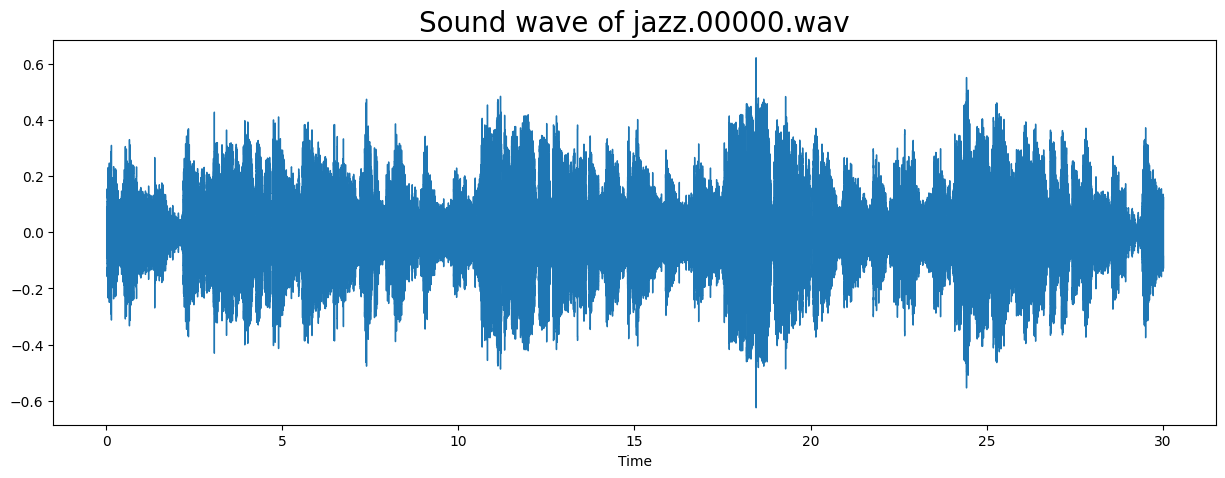

In [ ]:
y, sample_rate = librosa.load(sample_path)

print('y:', y, '\n')
print('y shape:', np.shape(y), '\n')
print('Sample rate (KHz):', sample_rate, '\n')
print(f'Length of audio: {np.shape(y)[0]/sample_rate}')

# Plot th sound wave.

plt.figure(figsize=(15, 5))
librosa.display.waveshow(y=y, sr=sample_rate);
plt.title("Sound wave of jazz.00000.wav", fontsize=20)
plt.show()

Shape of D object: (1025, 1293)


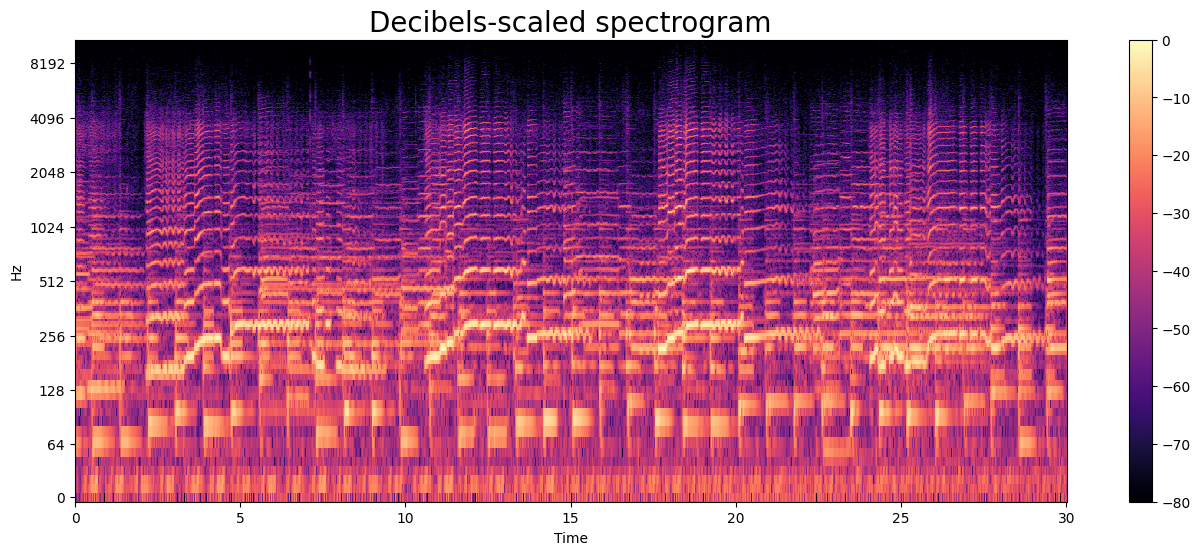

In [ ]:
# Convert sound wave to spectrogram.

# Short-time Fourier transform (STFT).

D = np.abs(librosa.stft(y, n_fft=2048, hop_length=512))
print('Shape of D object:', np.shape(D))

# Convert amplitude spectrogram to Decibels-scaled spectrogram.

DB = librosa.amplitude_to_db(D, ref = np.max)

# Creating the spectogram.

plt.figure(figsize = (16, 6))
librosa.display.specshow(DB, sr=sample_rate, hop_length=512,
                         x_axis='time', y_axis='log')
plt.colorbar()
plt.title('Decibels-scaled spectrogram', fontsize=20)
plt.show()

The mel spectrogram uses mel sclae intead of a linear one: [mel scale](https://en.wikipedia.org/wiki/Mel_scale) is a perceptual scale of pitches judged by listeners to be equal in distance from one another. The reference point between this scale and normal frequency measurement is defined by assigning a perceptual pitch of 1000 mels to a 1000 Hz tone, 40 dB above the listener's threshold. Above about 500 Hz, increasingly large intervals are judged by listeners to produce equal pitch increments.

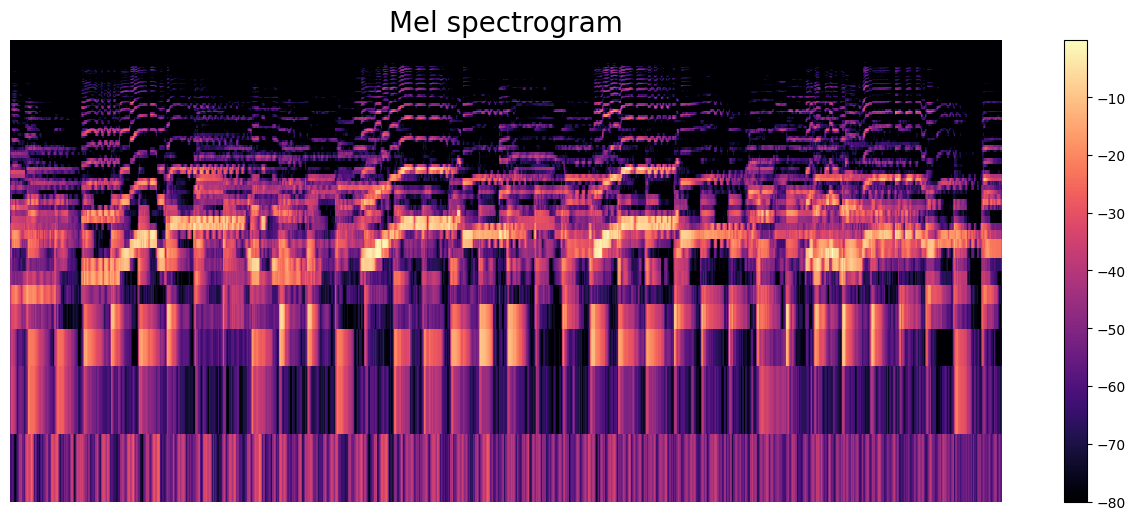

In [ ]:
# Convert sound wave to mel spectrogram.

y, sr = librosa.load(sample_path)

S = librosa.feature.melspectrogram(y=y, sr=sr)
S_DB = librosa.amplitude_to_db(S, ref=np.max)
plt.figure(figsize=(16, 6))
librosa.display.specshow(S_DB, sr=sr, hop_length=512,
                         x_axis='time', y_axis='log')
plt.colorbar()
plt.title("Mel spectrogram", fontsize=20)
plt.axis(False)
plt.show()

In [ ]:
window_size = 1024
window = np.hanning(window_size)
stft  = librosa.core.spectrum.stft(y[:len(y)//10], n_fft=window_size, hop_length=512, window=window)
out = 2 * np.abs(stft) / np.sum(window)

fig = plt.Figure()
canvas = FigureCanvas(fig)
ax = fig.add_subplot(111)
p = librosa.display.specshow(librosa.amplitude_to_db(out, ref=np.max), ax=ax)
fig.savefig('spec.png',transparent="True", pad_inches=0)

(288, 432, 4)


<ipython-input-15-336fea512865>:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(img_path)


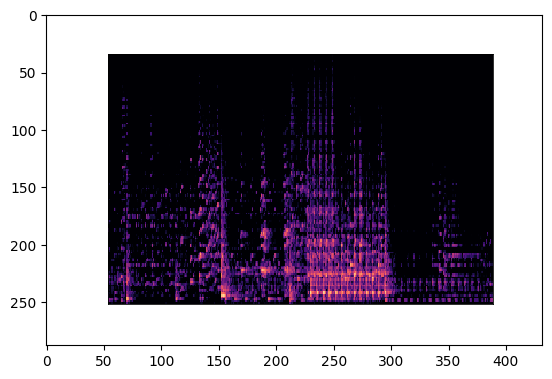

In [ ]:
# Visualize the mel spectrogram of the same sample from the dataset.

img_path = 'Data/images_original/jazz/jazz00000.png'
img = imageio.imread(img_path)
print(img.shape)

plt.imshow(img, interpolation='nearest')
plt.show()

# The 3 Second Dataset
The spectrograms can be created using the decibel scale or the mel scale

## Create the 3 second dataset
**WARNING: NO NEED TO RUN THIS SECTION**

In [ ]:
def make_spectrograms(path, genre, num=10, mel=False):
  y, sr = librosa.load(path)
  _, id, _ = path.split('.')
  size = len(y)//num
  window_size = 1024
  window = np.hanning(window_size)
  for i in range(num):
    if mel:
      S = librosa.feature.melspectrogram(y=y[i * size:(i+1) * size], sr=sr)
      # save
      fig = plt.Figure()
      canvas = FigureCanvas(fig)
      ax = fig.add_subplot(111)
      p = librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max), ax=ax)
      fig.savefig("Data/3sec/mel/" + genre + '/' + genre + "." + str(id) + str(i) + '.png',transparent="True", pad_inches=0)
    else:
      stft  = librosa.core.spectrum.stft(y[i * size:(i+1) * size],
                              n_fft=window_size, hop_length=512, window=window)
      out = 2 * np.abs(stft) / np.sum(window)
      # save
      fig = plt.Figure()
      canvas = FigureCanvas(fig)
      ax = fig.add_subplot(111)
      p = librosa.display.specshow(librosa.amplitude_to_db(out, ref=np.max), ax=ax)
      fig.savefig("Data/3sec/decibel/" + genre + '/' + genre + "." + str(id) + str(i) + '.png',transparent="True", pad_inches=0)

In [ ]:
def see_progress(mel=False):
  music_dir = "Data/genres_original/"
  genres = list(os.listdir(music_dir))
  if mel:
    folder_names = ['Data/3sec/mel/' + genre for genre in genres]
  else:
    folder_names = ['Data/3sec/decibel/' + genre for genre in genres]
  not_done = []
  for folder in folder_names:
    l = len([name for name in os.listdir(folder) if os.path.isfile(os.path.join(folder, name))])
    print(folder, l)
    if l != 1000:
      d, s, t, g = folder.split('/')
      not_done.append(g)
  return not_done
see_progress(mel=True)

In [ ]:
def make_dir(mel=False):
  music_dir = "Data/genres_original/"
  genres = list(os.listdir(music_dir))
  path = 'Data/3sec/mel/' if mel else 'Data/3sec/decibel/'
  # make main dir
  if os.path.exists(path):
    shutil.rmtree(path)
    os.mkdir(path)
  else:
    os.mkdir(path)
  # make genre dir
  folder_names = [path + genre for genre in genres]
  for f in folder_names:
    if os.path.exists(f):
      shutil.rmtree(f)
      os.mkdir(f)
    else:
      os.mkdir(f)

def make_3sec_dataset(mel=False):
  make_dir(mel)
  # Loop over all genres.
  for g in see_progress(mel=mel):
    src_file_paths= []
    for path in glob.glob(os.path.join(music_dir, f'{g}',"*.wav"), recursive=True):
      try:
        make_spectrograms(path, genre=g, mel=mel)
      except:
        print('fail', path)
    print(g, 'is done')


music_dir = "Data/genres_original/"
genres = list(os.listdir(music_dir))
# create 3 second dataset
make_3sec_dataset()

### save new images in google drive
this step is only required once for creating the 3 sec version of the dataset so that we would be able to mount the drive and not create  the dataset every time!

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!cp -r /content/Data/3sec/ /content/gdrive/MyDrive/NMA/

## Load the 3 second dataset
once the dataset is made and is available in google drive, we can run the following cell to mount the drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Pretraining steps

In [ ]:
# @title Helper functions (run me)

def set_device():
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
      print("WARNING: For this notebook to perform best, "
          "if possible, in the menu under `Runtime` -> "
          "`Change runtime type.`  select `GPU` ")
  else:
      print("GPU is enabled in this notebook.")

  return device


def plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc):
  epochs = len(train_loss)
  fig, (ax1, ax2) = plt.subplots(1, 2)
  ax1.plot(list(range(epochs)), train_loss, label='Training Loss')
  ax1.plot(list(range(epochs)), validation_loss, label='Validation Loss')
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss')
  ax1.set_title('Epoch vs Loss')
  ax1.legend()

  ax2.plot(list(range(epochs)), train_acc, label='Training Accuracy')
  ax2.plot(list(range(epochs)), validation_acc, label='Validation Accuracy')
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Accuracy')
  ax2.set_title('Epoch vs Accuracy')
  ax2.legend()
  fig.set_size_inches(15.5, 5.5)
  plt.show()

In [ ]:
device = set_device()

GPU is enabled in this notebook.


In [ ]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

## original dataset
used for loading the 30 second dataset

In [ ]:
# Create folder with training, testing and validation data.

spectrograms_dir = "Data/images_original/"
folder_names = ['Data/train/', 'Data/test/', 'Data/val/']
train_dir = folder_names[0]
test_dir = folder_names[1]
val_dir = folder_names[2]

for f in folder_names:
  if os.path.exists(f):
    shutil.rmtree(f)
    os.mkdir(f)
  else:
    os.mkdir(f)

# Loop over all genres.

genres = list(os.listdir(spectrograms_dir))
for g in genres:
  # find all images & split in train, test, and validation
  src_file_paths= []
  for im in glob.glob(os.path.join(spectrograms_dir, f'{g}',"*.png"), recursive=True):
    src_file_paths.append(im)
  random.shuffle(src_file_paths)
  test_files = src_file_paths[0:10]
  val_files = src_file_paths[10:20]
  train_files = src_file_paths[20:]

  #  make destination folders for train and test images
  for f in folder_names:
    if not os.path.exists(os.path.join(f + f"{g}")):
      os.mkdir(os.path.join(f + f"{g}"))

  # copy training and testing images over
  for f in train_files:
    shutil.copy(f, os.path.join(os.path.join(train_dir + f"{g}") + '/',os.path.split(f)[1]))
  for f in test_files:
    shutil.copy(f, os.path.join(os.path.join(test_dir + f"{g}") + '/',os.path.split(f)[1]))
  for f in val_files:
    shutil.copy(f, os.path.join(os.path.join(val_dir + f"{g}") + '/',os.path.split(f)[1]))

In [ ]:
# Data loading.

train_dataset = datasets.ImageFolder(
    train_dir,
    transforms.Compose([
        transforms.ToTensor(),
    ]))

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=32, shuffle=True, num_workers=0)

val_dataset = datasets.ImageFolder(
    val_dir,
    transforms.Compose([
        transforms.ToTensor(),
    ]))

val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=32, shuffle=True, num_workers=0)


# test
test_dataset = datasets.ImageFolder(
    test_dir,
    transforms.Compose([
        transforms.ToTensor(),
    ]))

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=10, shuffle=False, num_workers=0)

## three second dataset
keep in mind we must first specify which dataset (decibel or mel) we are going to use, here we use the mel scaled spectrograms

In [ ]:
# Create folder with training, testing and validation data.

spectrograms_dir = "drive/MyDrive/NMA/3sec/mel"

# spectrograms_dir = "drive/MyDrive/NMA/3sec/decibel"

folder_names = ['Data/train3/', 'Data/test3/', 'Data/val3/']
train_dir3 = folder_names[0]
test_dir3 = folder_names[1]
val_dir3 = folder_names[2]

for f in folder_names:
  if os.path.exists(f):
    shutil.rmtree(f)
    os.mkdir(f)
  else:
    os.mkdir(f)

### method 1
shuffle all 3 second audio files

In [ ]:
# Loop over all genres.

genres = list(os.listdir(spectrograms_dir))
for g in genres:
  # find all images & split in train, test, and validation
  src_file_paths= []
  for im in glob.glob(os.path.join(spectrograms_dir, f'{g}',"*.png"), recursive=True):
    src_file_paths.append(im)
  random.shuffle(src_file_paths)
  test_files = src_file_paths[0:100]
  val_files = src_file_paths[100:200]
  train_files = src_file_paths[200:]

  #  make destination folders for train and test images
  for f in folder_names:
    if not os.path.exists(os.path.join(f + f"{g}")):
      os.mkdir(os.path.join(f + f"{g}"))

  # copy training and testing images over
  for f in train_files:
    shutil.copy(f, os.path.join(os.path.join(train_dir3 + f"{g}") + '/',os.path.split(f)[1]))
  for f in test_files:
    shutil.copy(f, os.path.join(os.path.join(test_dir3 + f"{g}") + '/',os.path.split(f)[1]))
  for f in val_files:
    shutil.copy(f, os.path.join(os.path.join(val_dir3 + f"{g}") + '/',os.path.split(f)[1]))

### method 2
first split into test and train/valid data and then shuffle the train/valid

In [ ]:
# Loop over all genres.

genres = list(os.listdir(spectrograms_dir))
for g in genres:
  # find all images & split in train, test, and validation
  src_file_paths= []
  for im in glob.glob(os.path.join(spectrograms_dir, f'{g}',"*.png"), recursive=True):
    src_file_paths.append(im)
# print(src_file_paths)
  # random.shuffle(src_file_paths)
  test_files = src_file_paths[0:100]
  val_files = src_file_paths[100:200]
  # random.shuffle(src_file_paths[200:])
  train_files = src_file_paths[200:]

  #  make destination folders for train and test images
  for f in folder_names:
    if not os.path.exists(os.path.join(f + f"{g}")):
      os.mkdir(os.path.join(f + f"{g}"))

  # copy training and testing images over
  for f in train_files:
    shutil.copy(f, os.path.join(os.path.join(train_dir3 + f"{g}") + '/',os.path.split(f)[1]))
  for f in test_files:
    shutil.copy(f, os.path.join(os.path.join(test_dir3 + f"{g}") + '/',os.path.split(f)[1]))
  for f in val_files:
    shutil.copy(f, os.path.join(os.path.join(val_dir3 + f"{g}") + '/',os.path.split(f)[1]))

### Data loading

In [ ]:
# Data loading.

train_dataset3 = datasets.ImageFolder(
    train_dir3,
    transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((180, 240))
    ]))

train_loader3 = torch.utils.data.DataLoader(
    train_dataset3, batch_size=128, shuffle=True, num_workers=0)

val_dataset3 = datasets.ImageFolder(
    val_dir3,
    transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((180, 240))
    ]))

val_loader3 = torch.utils.data.DataLoader(
    val_dataset3, batch_size=128, shuffle=True, num_workers=0)


# test
test_dataset3 = datasets.ImageFolder(
    test_dir3,
    transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((180, 240))
    ]))

test_loader3 = torch.utils.data.DataLoader(test_dataset3, batch_size=100, shuffle=False, num_workers=0)

# for majority voting
majority_voting_loader = torch.utils.data.DataLoader(test_dataset3, batch_size=10, shuffle=False, num_workers=0)

### confusion matrix plotting
this function also returns accuracy of the test dataset

In [ ]:
def plot_conf_mat(net, three_sec=False):
  loader = test_loader3 if three_sec else test_loader
  color_threshhold = 50 if three_sec else 5
  total = 1000 if three_sec else 100
  # create the confusion matrix and store the count of correct predictions
  conf_mat = torch.zeros(10, 10)
  correct = 0
  net.eval()
  with torch.no_grad():
    for x, y in loader:
      x, y = x.to(device), y.to(device)
      pred = torch.argmax(net(x), axis=1)
      for j in range(pred.shape[0]):
        try:
          conf_mat[y[j], pred[j].item()] += 1
        except:
          # print(y[j], pred[j].item())
          pass
  # plot the matrix
  fig, ax = plt.subplots()
  plt.imshow(conf_mat)
  plt.title('Confusion Matrix')
  genres = ['blues', 'classcial', 'country', 'disco', 'hiphop',
            'jazz', 'metal', 'pop', 'reggae', 'rock']
  plt.xticks(range(10), labels=genres, rotation=45)
  plt.xlabel('Predicted Genres')
  plt.yticks(range(10), labels=genres)
  plt.ylabel('Real Genres')
  plt.colorbar()
  for i in range(10):
    for j in range(10):
      c = conf_mat[j, i]
      color = 'black' if c > color_threshhold else 'white'
      ax.text(i, j, str(int(c)), va='center', ha='center', color=color)
  plt.show()
  correct = torch.diagonal(conf_mat, 0).sum()
  return correct.item()/total

### ensemble

In [ ]:
def ensemble(model, majority_voting=False):
  # create the confusion matrix and accuracy
  conf_mat = torch.zeros(10, 10)
  model.eval()
  with torch.no_grad():
    for img, lbl in majority_voting_loader:
        img, lbl = img.to(device), lbl.to(device)
        pred = model(img)
        if majority_voting:
          # find vote on each segment
          pred = torch.argmax(pred, axis=1)
          # find most votes
          pred = torch.mode(pred).values.item()
        else:
          # apply softmax to get probabilities
          pred = F.softmax(pred, dim=1)
          # take log so we can add
          pred = torch.log(pred)
          # add probability of each class
          pred = torch.sum(pred, axis=0)
          # choose class with highest probability
          pred = torch.argmax(pred)
        # update confusion matrix
        conf_mat[lbl[0], pred] += 1
  # plot the matrix
  fig, ax = plt.subplots()
  plt.imshow(conf_mat)
  plt.title('Confusion Matrix')
  genres = ['blues', 'classcial', 'country', 'disco', 'hiphop',
              'jazz', 'metal', 'pop', 'reggae', 'rock']
  plt.xticks(range(10), labels=genres, rotation=45)
  plt.xlabel('Predicted Genres')
  plt.yticks(range(10), labels=genres)
  plt.ylabel('Real Genres')
  plt.colorbar()
  for i in range(10):
    for j in range(10):
      c = conf_mat[j, i]
      color = 'black' if c > 5 else 'white'
      ax.text(i, j, str(int(c)), va='center', ha='center', color=color)
  plt.show()
  correct = torch.diagonal(conf_mat, 0).sum()
  txt = 'Majority Voting' if majority_voting else 'Probabilistic'
  print(txt, 'Accuracy=', correct.item()/100)

# Classification

## Train a simple CNN

look into [me](https://www.projectpro.io/article/music-genre-classification-project-python-code/566) as well

In [ ]:
# Make a CNN & train it to predict genres.

class music_net(nn.Module):
  def __init__(self):
    """Intitalize neural net layers"""
    super(music_net, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=1, padding=0)
    self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=0)
    self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=0)
    self.conv4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=0)
    self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=0)
    self.fc1 = nn.Linear(in_features=9856, out_features=10)

    self.batchnorm1 = nn.BatchNorm2d(num_features=8)
    self.batchnorm2 = nn.BatchNorm2d(num_features=16)
    self.batchnorm3 = nn.BatchNorm2d(num_features=32)
    self.batchnorm4 = nn.BatchNorm2d(num_features=64)
    self.batchnorm5 = nn.BatchNorm2d(num_features=128)

    self.dropout = nn.Dropout(p=0.3, inplace=False)


  def forward(self, x):
    # Conv layer 1.
    x = self.conv1(x)
    x = self.batchnorm1(x)
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=2)

    # Conv layer 2.
    x = self.conv2(x)
    x = self.batchnorm2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=2)

    # Conv layer 3.
    x = self.conv3(x)
    x = self.batchnorm3(x)
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=2)

    # Conv layer 4.
    x = self.conv4(x)
    x = self.batchnorm4(x)
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=2)

    # Conv layer 5.
    x = self.conv5(x)
    x = self.batchnorm5(x)
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=2)

    # Fully connected layer 1.
    x = torch.flatten(x, 1)
    x = self.dropout(x)
    x = self.fc1(x)
    # x = F.softmax(x)

    return x


def train(model, device, train_loader, validation_loader, epochs):
  criterion =  nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
  train_loss, validation_loss = [], []
  train_acc, validation_acc = [], []
  with tqdm(range(epochs), unit='epoch') as tepochs:
    tepochs.set_description('Training')
    for epoch in tepochs:
      model.train()
      # keep track of the running loss
      running_loss = 0.
      correct, total = 0, 0

      for data, target in train_loader:
        # getting the training set
        data, target = data.to(device), target.to(device)
        # Get the model output (call the model with the data from this batch)
        output = model(data)
        # Zero the gradients out)
        optimizer.zero_grad()
        # Get the Loss
        loss  = criterion(output, target)
        # Calculate the gradients
        loss.backward()
        # Update the weights (using the training step of the optimizer)
        optimizer.step()

        tepochs.set_postfix(loss=loss.item())
        running_loss += loss  # add the loss for this batch

        # get accuracy
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

      # append the loss for this epoch
      train_loss.append(running_loss.detach().cpu().item()/len(train_loader))
      train_acc.append(correct/total)

      # evaluate on validation data
      model.eval()
      running_loss = 0.
      correct, total = 0, 0

      for data, target in validation_loader:
        # getting the validation set
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        tepochs.set_postfix(loss=loss.item())
        running_loss += loss.item()
        # get accuracy
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

      validation_loss.append(running_loss/len(validation_loader))
      validation_acc.append(correct/total)

  return train_loss, train_acc, validation_loss, validation_acc

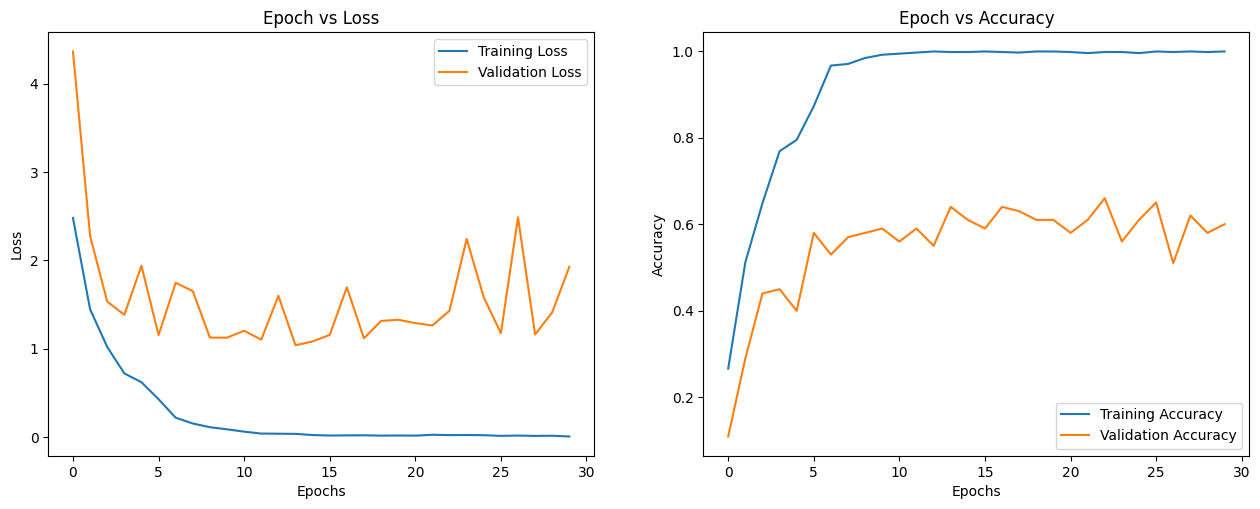

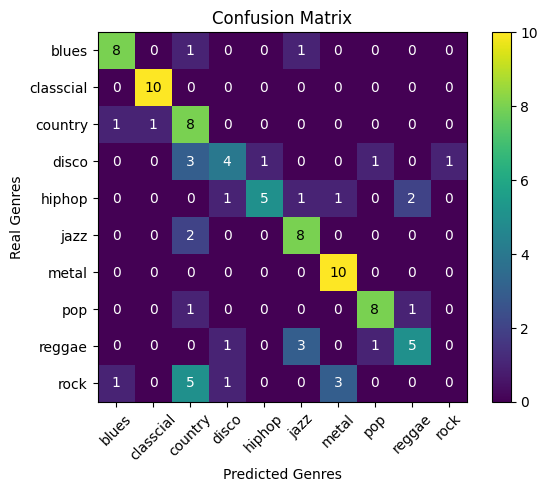

Test Accuracy: 0.66


In [ ]:
# Run training.
net = music_net().to(device)
train_loss, train_acc, validation_loss, validation_acc = train(net, device, train_loader, val_loader, 30)

# Detach tensors from GPU
plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)

# plot the confusion matrix
acc = plot_conf_mat(net)

print("Test Accuracy:", acc)

## Transfer Learning
First we add the train function for transfer learning which is the same as the other train function with slight adjustments and modifications:

In [ ]:
# @title Train function for Transfer Learning
def transfer_train(model, to_train, device, train_loader, validation_loader, epochs=10, lr=0.0004):
  model = model.to(device)
  criterion =  nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(to_train, lr=lr)
  train_loss, validation_loss = [], []
  train_acc, validation_acc = [], []
  with tqdm(range(epochs), unit='epoch') as tepochs:
    tepochs.set_description('Training')
    for epoch in tepochs:
      model.train()
      # keep track of the running loss
      running_loss = 0.
      correct, total = 0, 0

      for data, target in train_loader:
        # getting the training set
        data, target = data.to(device), target.to(device)
        # Get the model output (call the model with the data from this batch)
        output = model(data)
        # Zero the gradients out)
        optimizer.zero_grad()
        # Get the Loss
        loss  = criterion(output, target)
        # Calculate the gradients
        loss.backward()
        # Update the weights (using the training step of the optimizer)
        optimizer.step()

        tepochs.set_postfix(loss=loss.item())
        running_loss += loss  # add the loss for this batch

        # get accuracy
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

      # append the loss for this epoch
      train_loss.append(running_loss.detach().cpu().item()/len(train_loader))
      train_acc.append(correct/total)

      # evaluate on validation data
      model.eval()
      running_loss = 0.
      correct, total = 0, 0

      for data, target in validation_loader:
        # getting the validation set
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        tepochs.set_postfix(loss=loss.item())
        running_loss += loss.item()
        # get accuracy
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

      validation_loss.append(running_loss/len(validation_loader))
      validation_acc.append(correct/total)

  return train_loss, train_acc, validation_loss, validation_acc

### ResNet18 (no pre-taining)


#### original dataset

  0%|          | 0/30 [00:00<?, ?epoch/s]

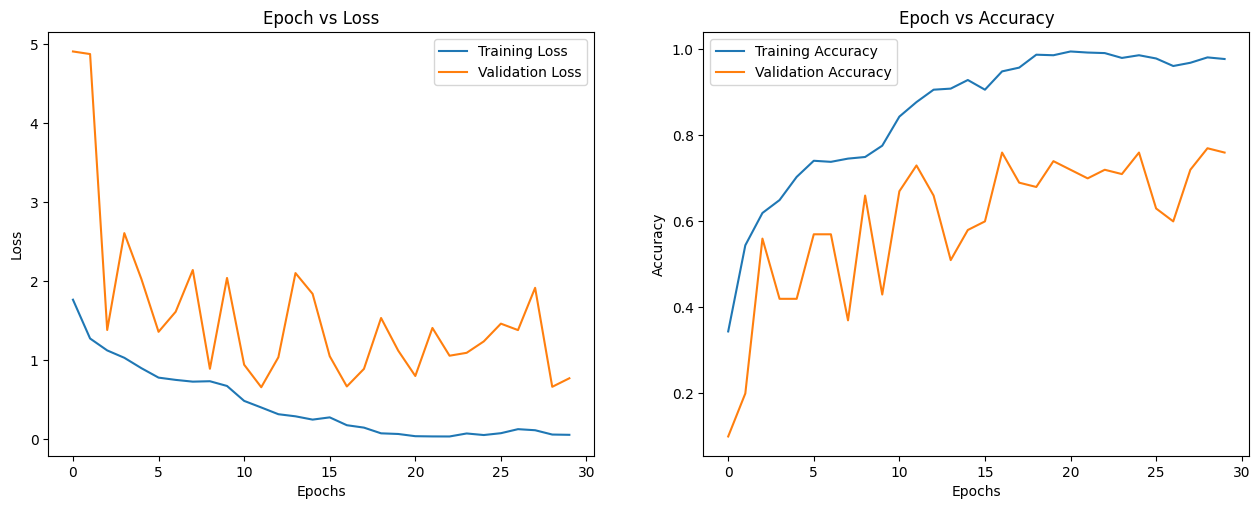

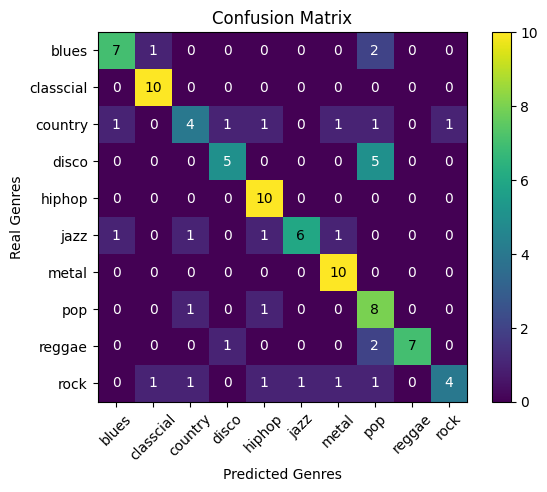

0.71

In [ ]:
resnet = torchvision.models.resnet18()
num_ftrs = resnet.fc.in_features
# Reset final fully connected layer
resnet.fc = nn.Linear(num_ftrs, 10)

train_loss, train_acc, validation_loss, validation_acc = transfer_train(resnet, resnet.parameters(), device, train_loader, val_loader, epochs=30)

# Detach tensors from GPU
plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)

plot_conf_mat(resnet)

#### three second dataset

  0%|          | 0/10 [00:00<?, ?epoch/s]

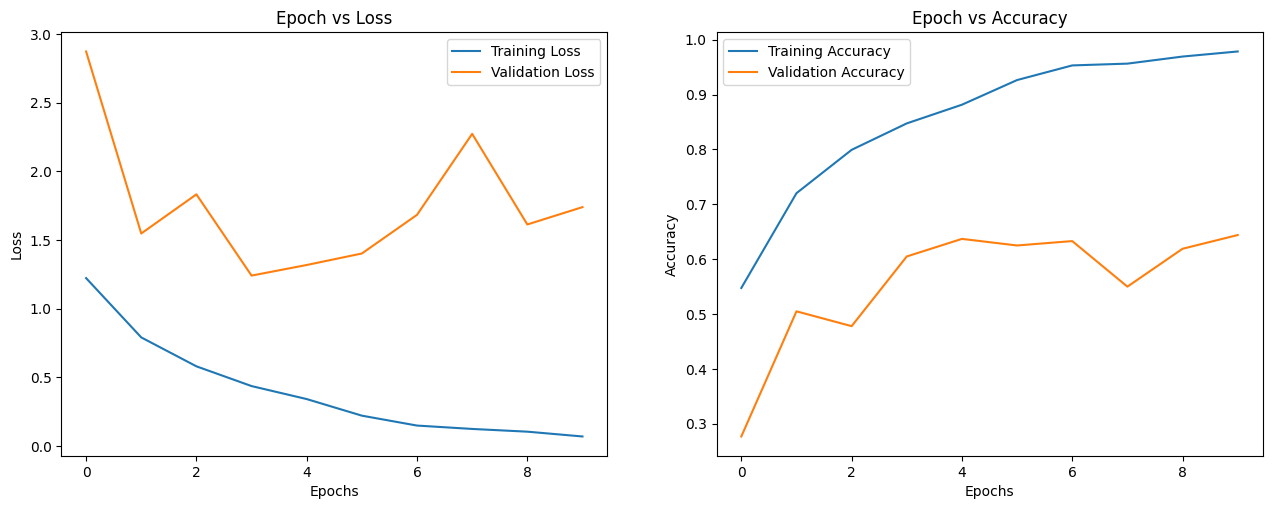

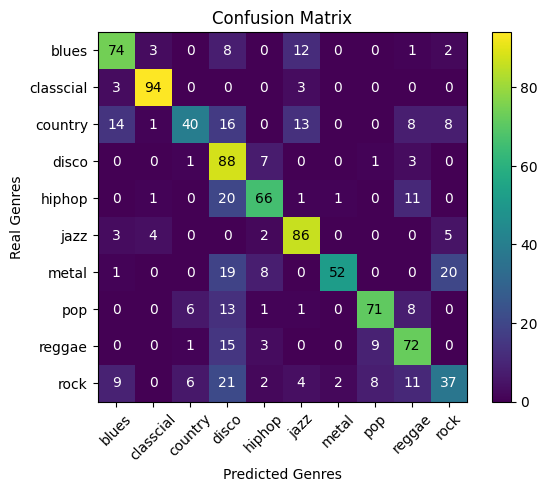

0.68

In [ ]:
resnet = torchvision.models.resnet18()
num_ftrs = resnet.fc.in_features
# Reset final fully connected layer
resnet.fc = nn.Linear(num_ftrs, 10)

train_loss, train_acc, validation_loss, validation_acc = transfer_train(resnet, resnet.parameters(), device, train_loader3, val_loader3, epochs=10)

# Detach tensors from GPU
plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)

plot_conf_mat(resnet, three_sec=True)

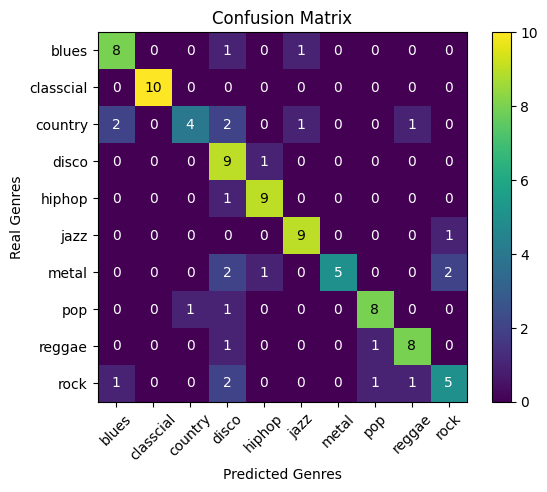

Majority Voting Accuracy= 0.75


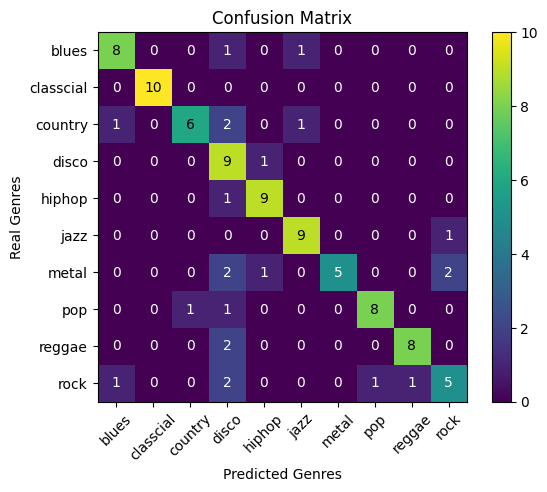

Probabilistic Accuracy= 0.77


In [ ]:
ensemble(resnet, True)
ensemble(resnet, False)

### ResNet18 full model

#### original dataset

  0%|          | 0/15 [00:00<?, ?epoch/s]

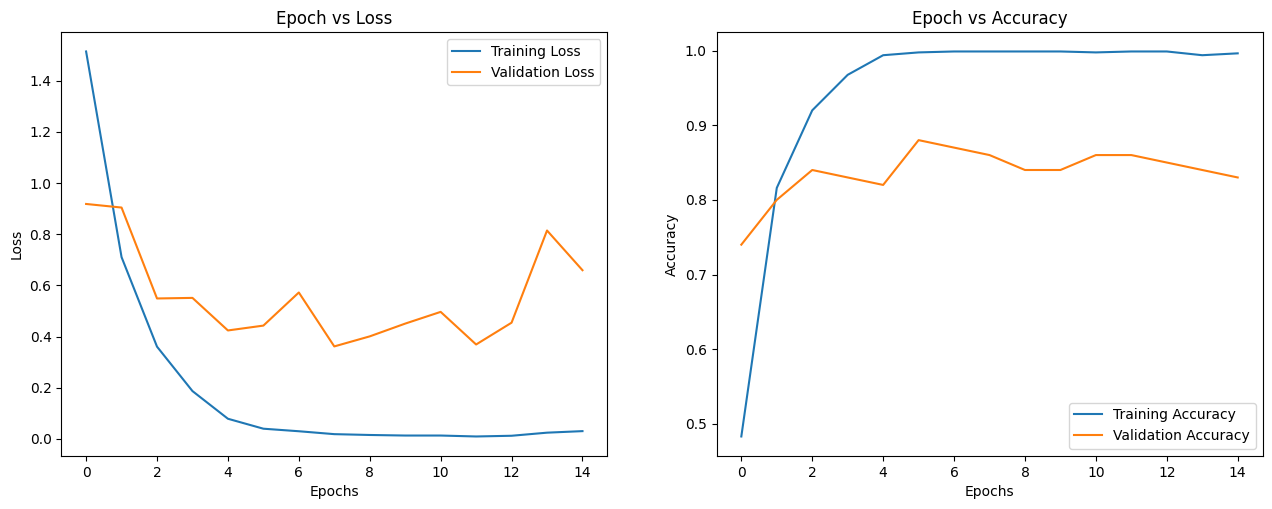

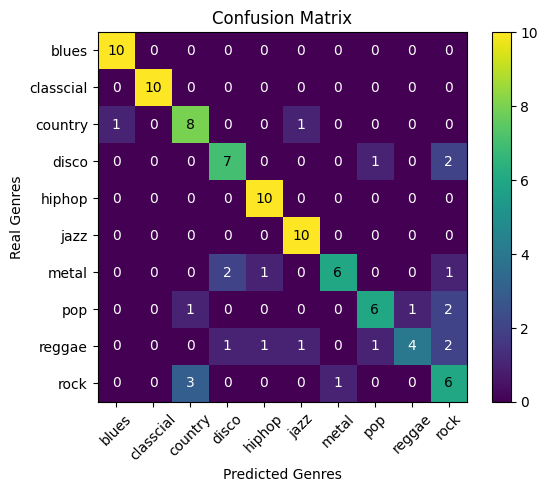

Test Accuracy: 0.77


In [ ]:
resnet = torchvision.models.resnet18(weights='ResNet18_Weights.DEFAULT')
num_ftrs = resnet.fc.in_features
# Reset final fully connected layer
resnet.fc = nn.Linear(num_ftrs, 10)

train_loss, train_acc, validation_loss, validation_acc = transfer_train(resnet, resnet.parameters(), device, train_loader, val_loader, epochs=15, lr=0.0001)

# Detach tensors from GPU
plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)

acc = plot_conf_mat(resnet)

print('Test Accuracy:', acc)

#### three second dataset

  0%|          | 0/10 [00:00<?, ?epoch/s]

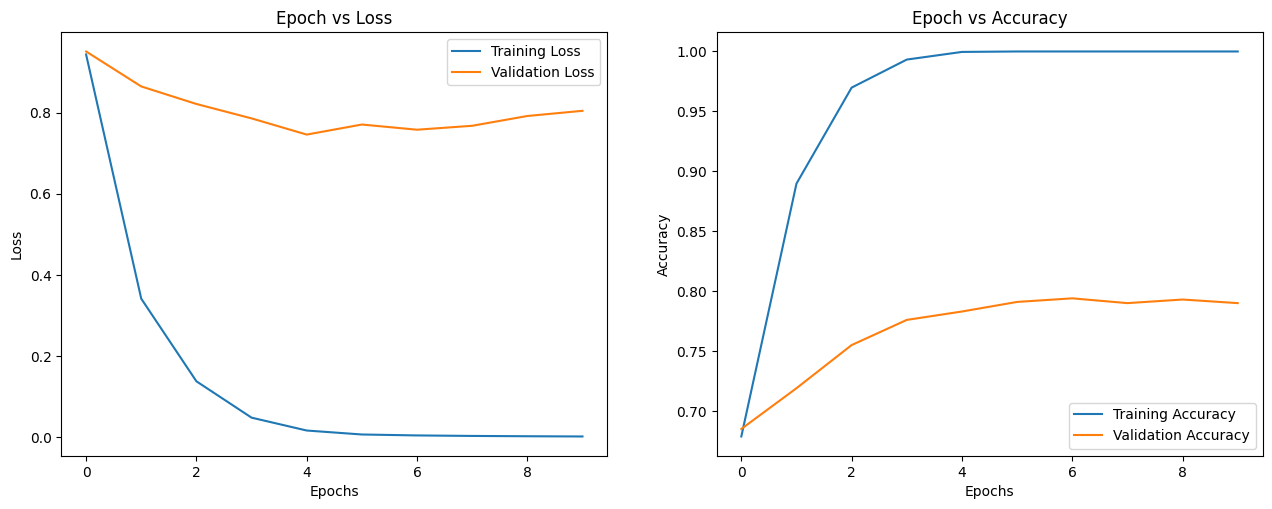

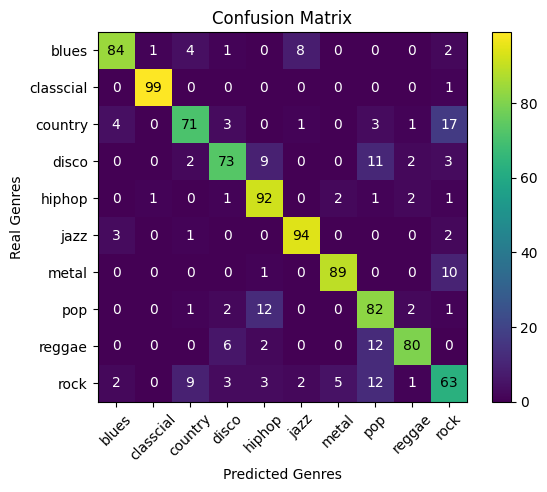

Test Accuracy: 0.827


In [ ]:
resnet = torchvision.models.resnet18(weights='ResNet18_Weights.DEFAULT')
num_ftrs = resnet.fc.in_features
# Reset final fully connected layer
resnet.fc = nn.Linear(num_ftrs, 10)

train_loss, train_acc, validation_loss, validation_acc = transfer_train(resnet, resnet.parameters(), device, train_loader3, val_loader3, epochs=10, lr=0.0001)

# Detach tensors from GPU
plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)

acc = plot_conf_mat(resnet, three_sec=True)

print('Test Accuracy:', acc)

#### Majority Voting

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


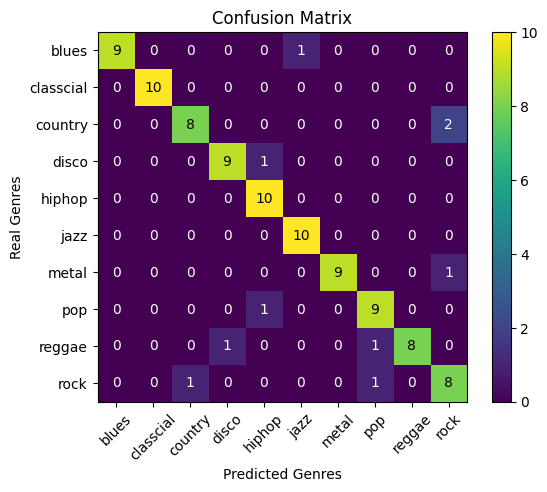

Majority Voting Accuracy= 0.9


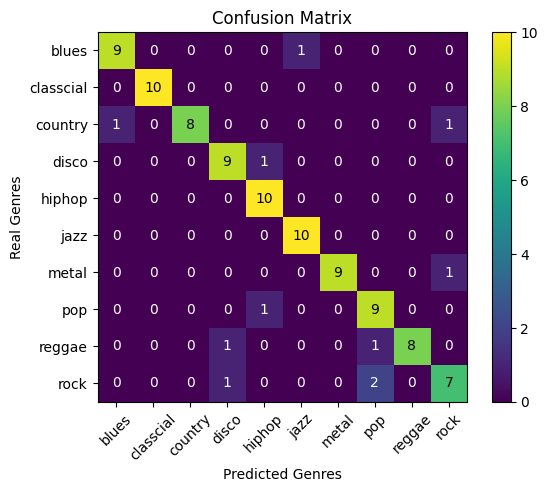

Probabilistic Accuracy= 0.89


In [ ]:
ensemble(resnet, True)
ensemble(resnet, False)

#### save the model

In [ ]:
# save the model
torch.save(resnet.state_dict(), 'ResNet18mel_3sec_MV')
# drive.mount('/content/gdrive')

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!cp -r /content/ResNet18mel_3sec_MV /content/gdrive/MyDrive/NMA/

### ResNet34 full model

#### original dataset

  0%|          | 0/15 [00:00<?, ?epoch/s]

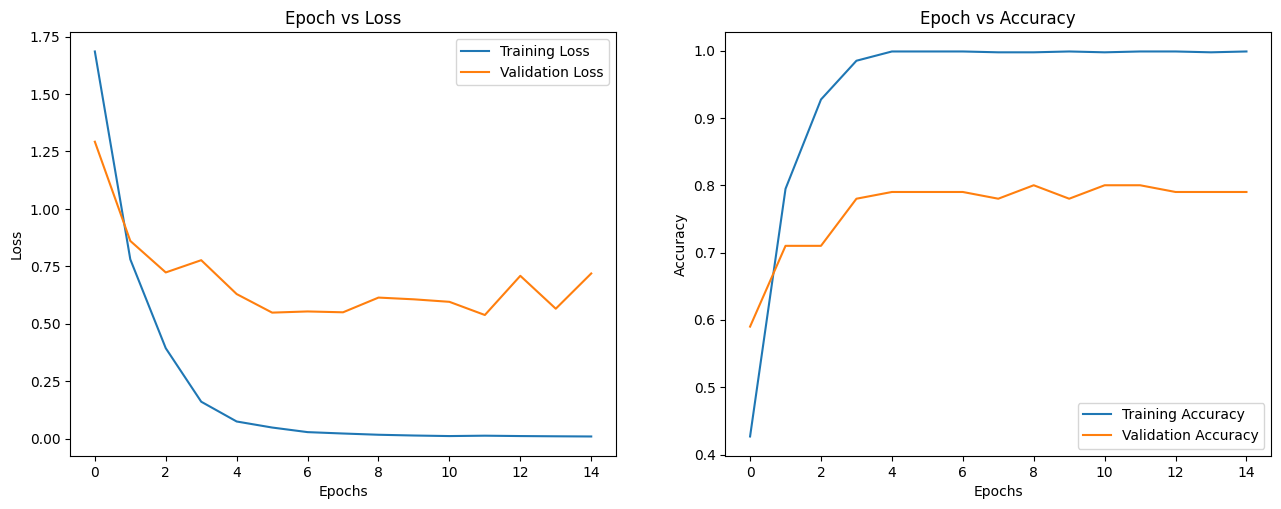

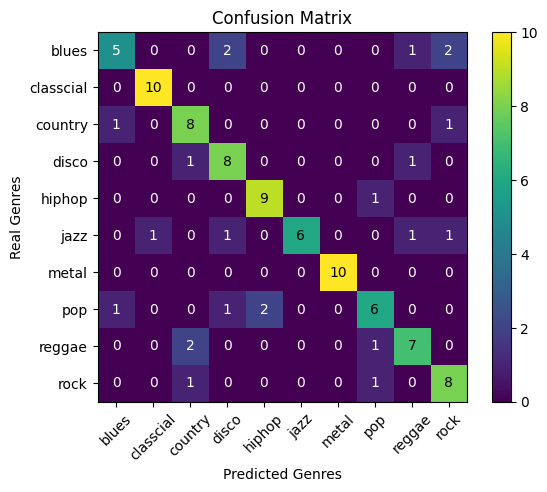

In [ ]:
resnet = torchvision.models.resnet34(weights='ResNet34_Weights.DEFAULT')
num_ftrs = resnet.fc.in_features
# Reset final fully connected layer
resnet.fc = nn.Linear(num_ftrs, 10)

train_loss, train_acc, validation_loss, validation_acc = transfer_train(resnet, resnet.parameters(), device, train_loader, val_loader, lr=0.00005, epochs=15)

# Detach tensors from GPU
plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)

plot_conf_mat(resnet)

#### three second dataset

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:05<00:00, 15.2MB/s]


  0%|          | 0/10 [00:00<?, ?epoch/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


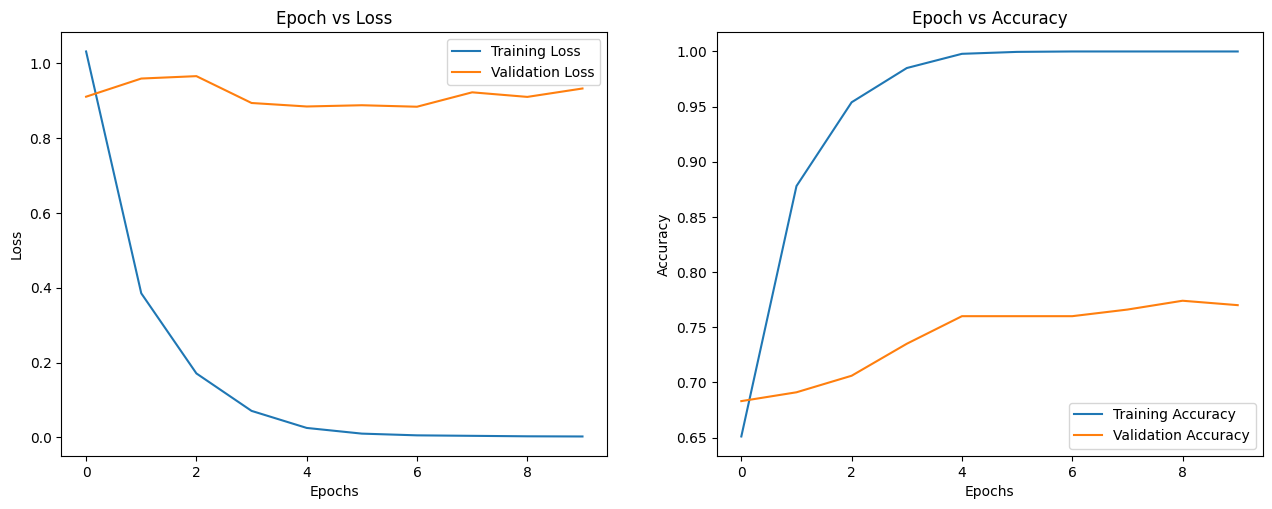

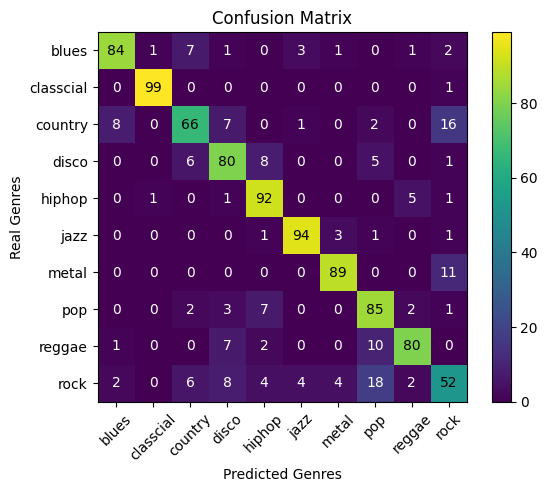

Test Accuracy: 0.821


In [ ]:
resnet = torchvision.models.resnet34(weights='ResNet34_Weights.DEFAULT')
num_ftrs = resnet.fc.in_features
# Reset final fully connected layer
resnet.fc = nn.Linear(num_ftrs, 10)

train_loss, train_acc, validation_loss, validation_acc = transfer_train(resnet, resnet.parameters(), device, train_loader3, val_loader3, epochs=10, lr=0.00005)

# Detach tensors from GPU
plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)

acc = plot_conf_mat(resnet, three_sec=True)

print('Test Accuracy:', acc)

#### Majority Voting

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


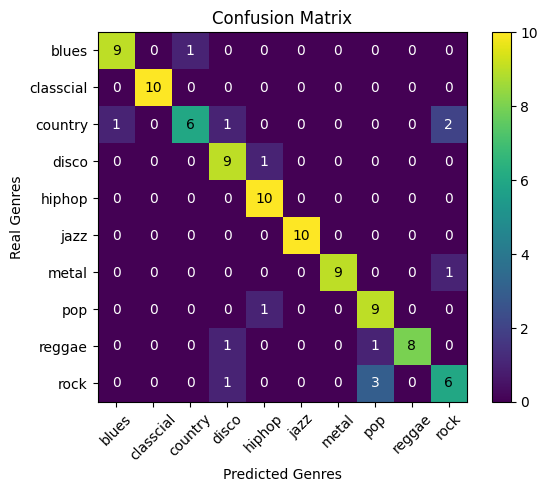

Majority Voting Accuracy= 0.86


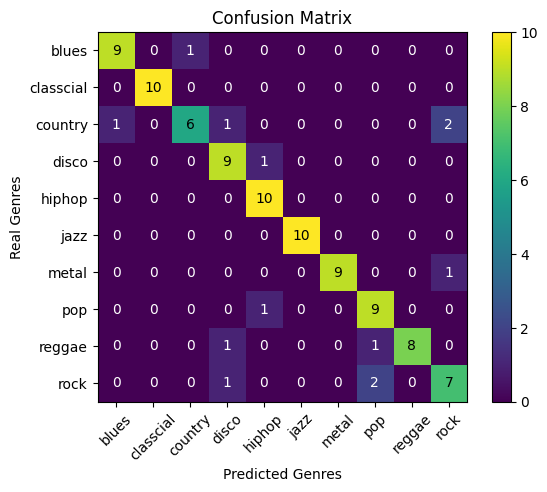

Probabilistic Accuracy= 0.87


In [ ]:
ensemble(resnet, True)
ensemble(resnet, False)

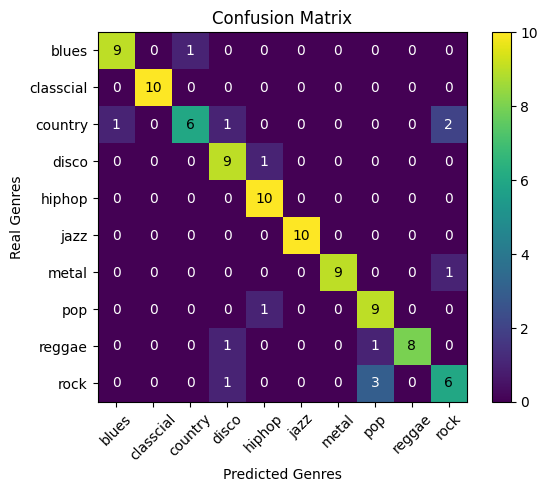

Majority Voting Accuracy= 0.86


In [ ]:
# create the confusion matrix and store the count of correct predictions
conf_mat = torch.zeros(10, 10)
resnet.eval()
with torch.no_grad():
  for img, lbl in majority_voting_loader:
      img, lbl = img.to(device), lbl.to(device)
      pred = torch.argmax(resnet(img), axis=1)
      majority_vote = torch.mode(pred)
      # print(pred, majority_vote.values.item(), lbl)
      # break
      try:
        conf_mat[lbl[0], majority_vote.values.item()] += 1
      except:
          print(majority_vote)
          break
          # print(y[j], pred[j].item())
          pass
# plot the matrix
fig, ax = plt.subplots()
plt.imshow(conf_mat)
plt.title('Confusion Matrix')
genres = ['blues', 'classcial', 'country', 'disco', 'hiphop',
            'jazz', 'metal', 'pop', 'reggae', 'rock']
plt.xticks(range(10), labels=genres, rotation=45)
plt.xlabel('Predicted Genres')
plt.yticks(range(10), labels=genres)
plt.ylabel('Real Genres')
plt.colorbar()
for i in range(10):
  for j in range(10):
    c = conf_mat[j, i]
    color = 'black' if c > 5 else 'white'
    ax.text(i, j, str(int(c)), va='center', ha='center', color=color)
plt.show()
correct = torch.diagonal(conf_mat, 0).sum()
print('Majority Voting Accuracy=', correct.item()/100)

###  GoogLeNet

  0%|          | 0/15 [00:00<?, ?epoch/s]

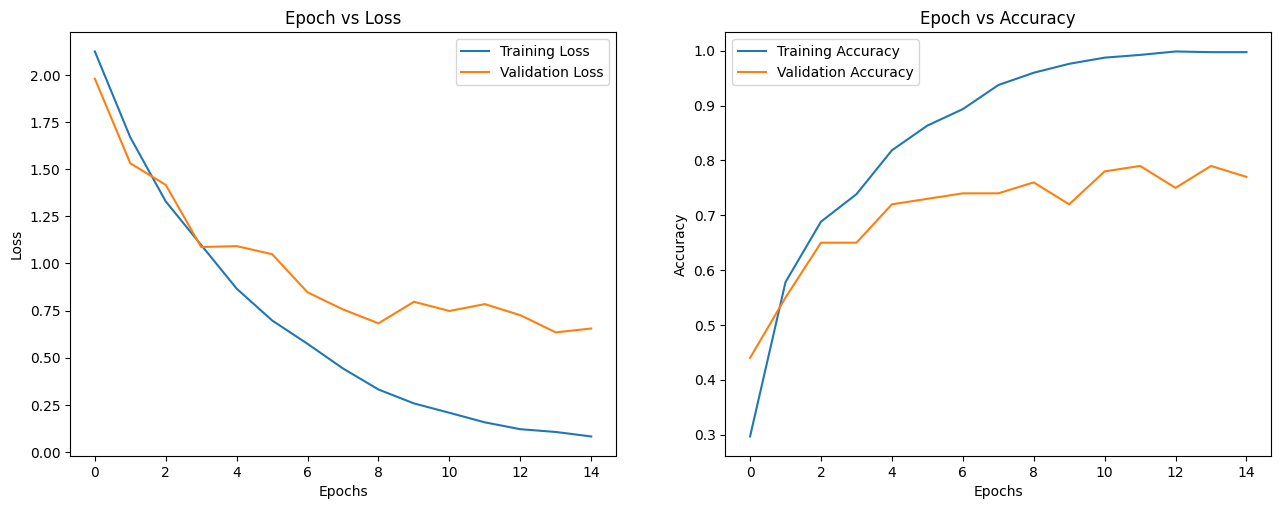

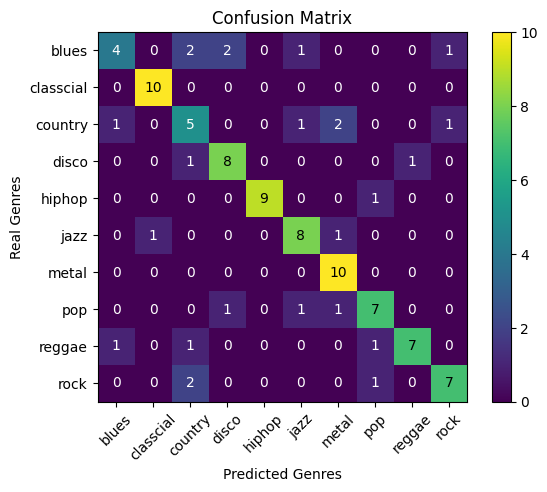

In [ ]:
googlenet = torchvision.models.googlenet(weights='DEFAULT')
num_ftrs = googlenet.fc.in_features
googlenet.fc = nn.Linear(num_ftrs, 10)

train_loss, train_acc, validation_loss, validation_acc = transfer_train(googlenet, googlenet.parameters(), device, train_loader, val_loader, lr=0.00005, epochs=15)

# Detach tensors from GPU
plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)

plot_conf_mat(googlenet)

three second dataset

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 128MB/s]


  0%|          | 0/10 [00:00<?, ?epoch/s]

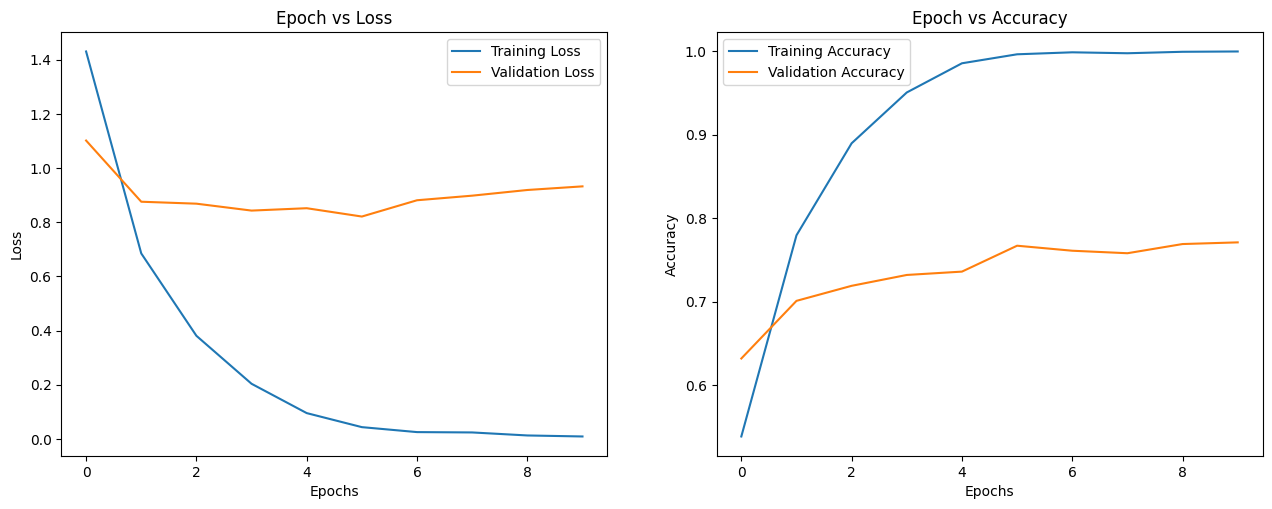

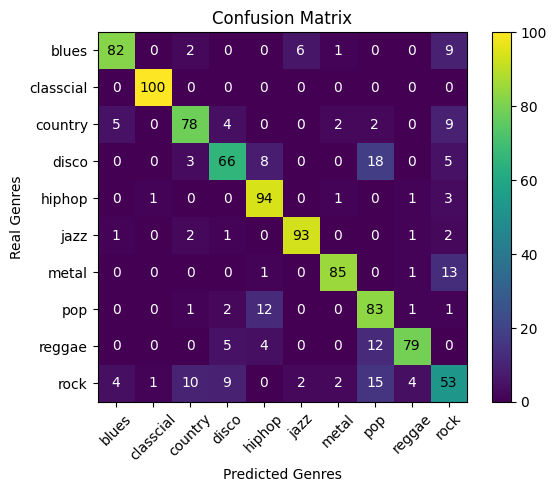

Test Accuracy: 0.813


In [ ]:
googlenet = torchvision.models.googlenet(weights='DEFAULT')
num_ftrs = googlenet.fc.in_features
# Reset final fully connected layer
googlenet.fc = nn.Linear(num_ftrs, 10)

train_loss, train_acc, validation_loss, validation_acc = transfer_train(googlenet, googlenet.parameters(), device, train_loader3, val_loader3, epochs=10, lr=0.0001)

# Detach tensors from GPU
plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)

acc = plot_conf_mat(googlenet, three_sec=True)

print('Test Accuracy:', acc)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


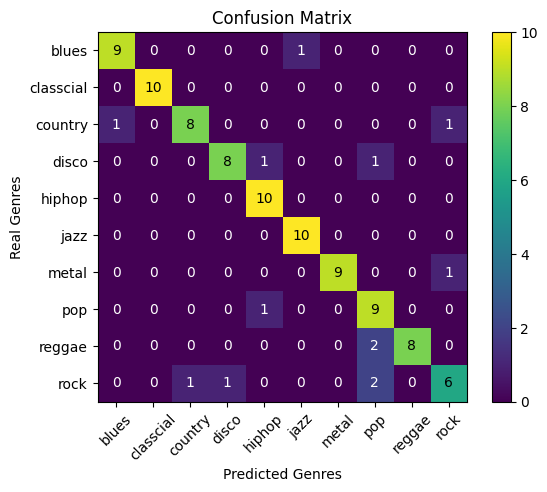

Majority Voting Accuracy= 0.87


In [ ]:
# create the confusion matrix and store the count of correct predictions
conf_mat = torch.zeros(10, 10)
googlenet.eval()
with torch.no_grad():
  for img, lbl in majority_voting_loader:
      img, lbl = img.to(device), lbl.to(device)
      pred = torch.argmax(googlenet(img), axis=1)
      majority_vote = torch.mode(pred)
      # print(pred, majority_vote.values.item(), lbl)
      # break
      try:
        conf_mat[lbl[0], majority_vote.values.item()] += 1
      except:
          print(majority_vote)
          break
          # print(y[j], pred[j].item())
          pass
# plot the matrix
fig, ax = plt.subplots()
plt.imshow(conf_mat)
plt.title('Confusion Matrix')
genres = ['blues', 'classcial', 'country', 'disco', 'hiphop',
            'jazz', 'metal', 'pop', 'reggae', 'rock']
plt.xticks(range(10), labels=genres, rotation=45)
plt.xlabel('Predicted Genres')
plt.yticks(range(10), labels=genres)
plt.ylabel('Real Genres')
plt.colorbar()
for i in range(10):
  for j in range(10):
    c = conf_mat[j, i]
    color = 'black' if c > 5 else 'white'
    ax.text(i, j, str(int(c)), va='center', ha='center', color=color)
plt.show()
correct = torch.diagonal(conf_mat, 0).sum()
print('Majority Voting Accuracy=', correct.item()/100)

# Mel


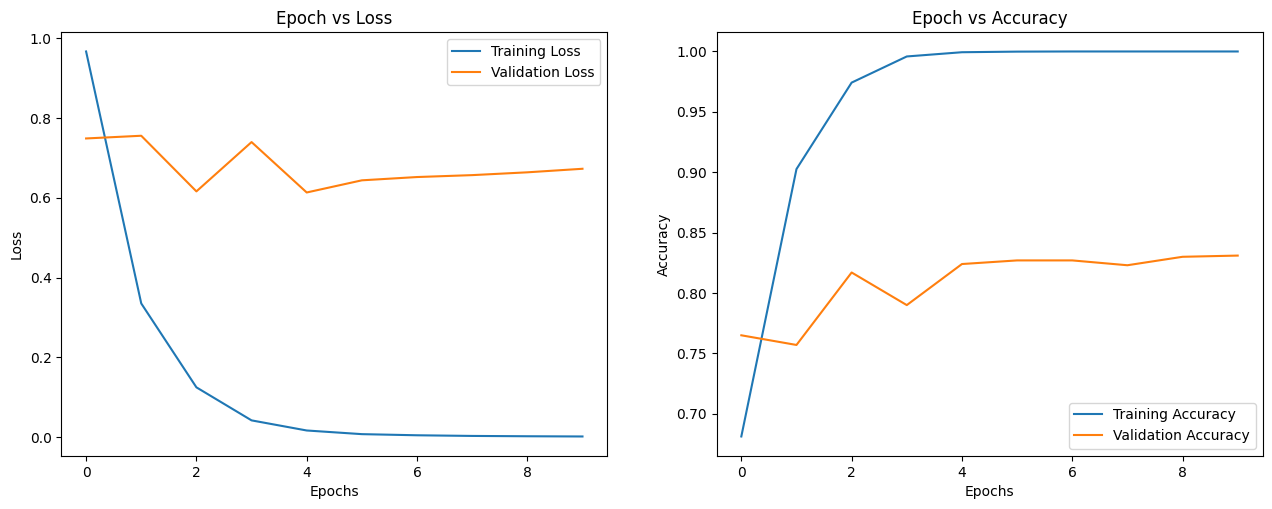

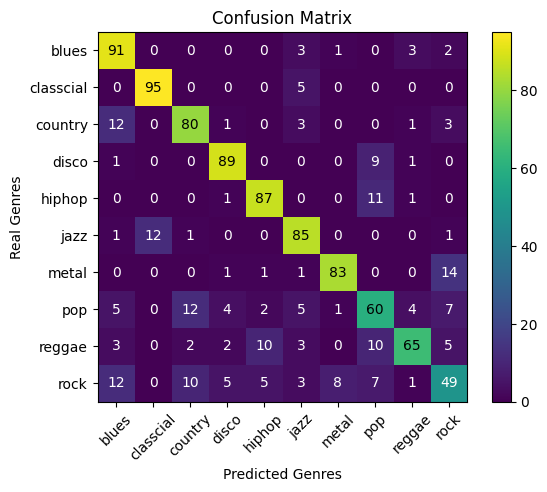

Test Accuracy: 0.784


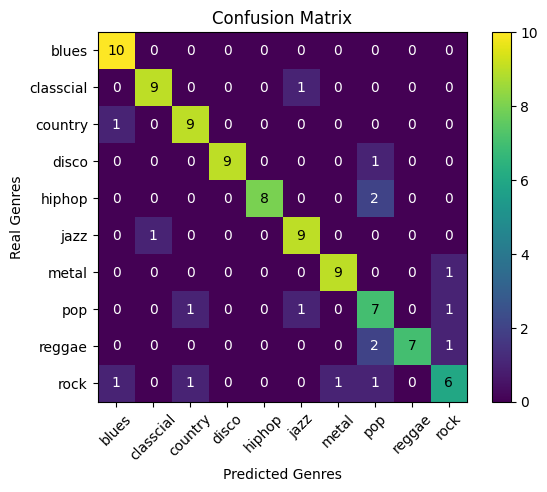

Majority Voting Accuracy= 0.83


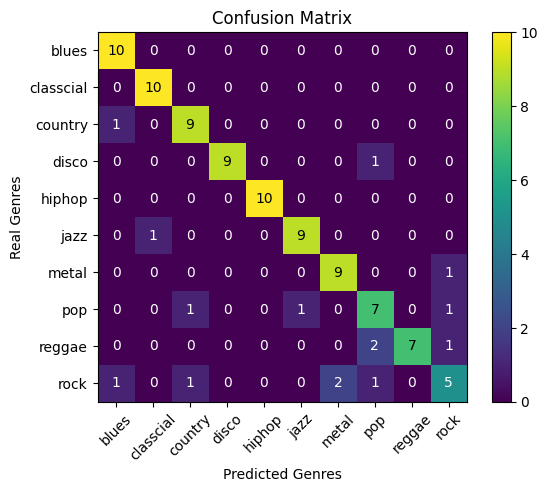

Probabilistic Accuracy= 0.85


In [ ]:
resnet = torchvision.models.resnet18(weights='ResNet18_Weights.DEFAULT')
num_ftrs = resnet.fc.in_features
# Reset final fully connected layer
resnet.fc = nn.Linear(num_ftrs, 10)

train_loss, train_acc, validation_loss, validation_acc = transfer_train(resnet, resnet.parameters(), device, train_loader3, val_loader3, epochs=10, lr=0.0001)

# Detach tensors from GPU
plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)

acc = plot_conf_mat(resnet, three_sec=True)

print('Test Accuracy:', acc)

ensemble(resnet, True)
ensemble(resnet, False)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 102MB/s]


  0%|          | 0/10 [00:00<?, ?epoch/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


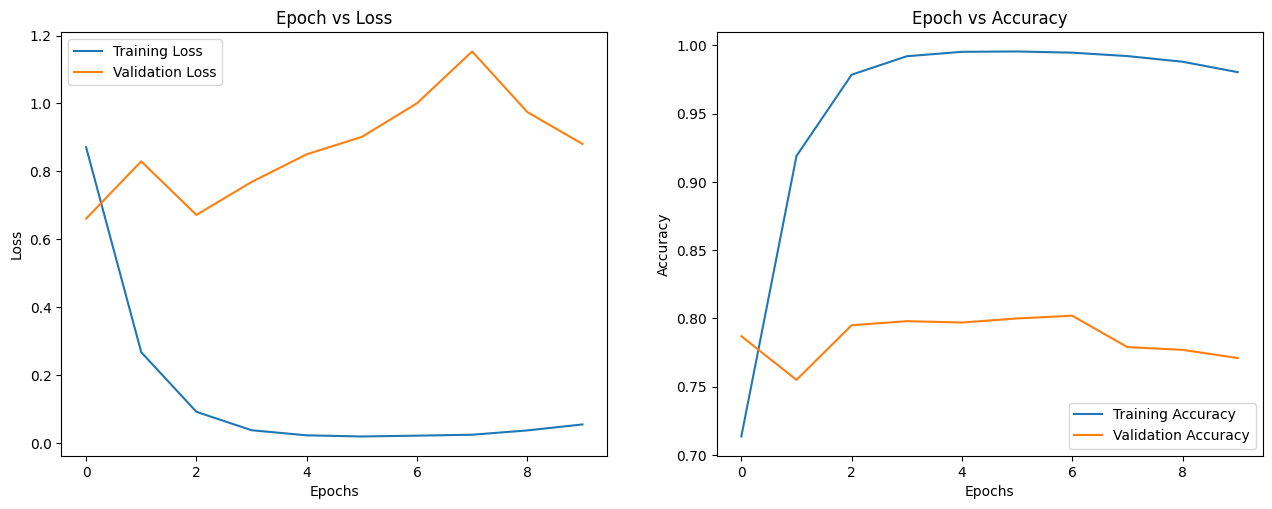

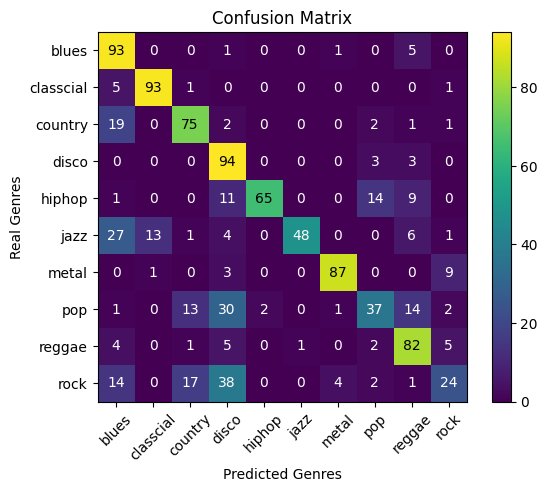

Test Accuracy: 0.698


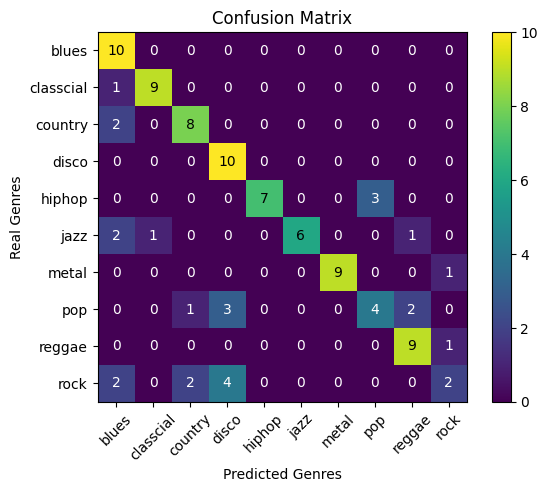

Majority Voting Accuracy= 0.74


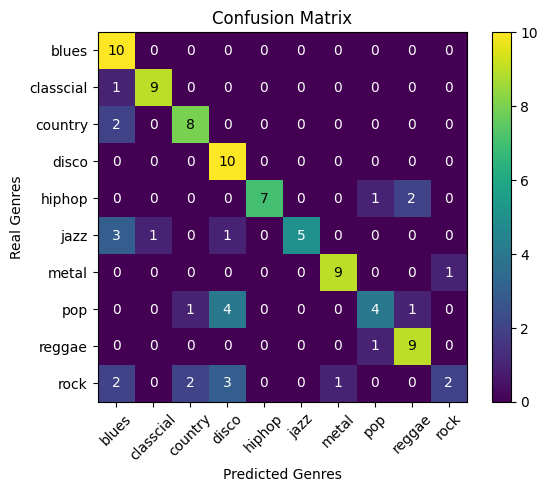

Probabilistic Accuracy= 0.73


In [ ]:
resnet = torchvision.models.resnet34(weights='ResNet34_Weights.DEFAULT')
num_ftrs = resnet.fc.in_features
# Reset final fully connected layer
resnet.fc = nn.Linear(num_ftrs, 10)

train_loss, train_acc, validation_loss, validation_acc = transfer_train(resnet, resnet.parameters(), device, train_loader3, val_loader3, epochs=10, lr=0.0001)

# Detach tensors from GPU
plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)

acc = plot_conf_mat(resnet, three_sec=True)

print('Test Accuracy:', acc)

ensemble(resnet, True)
ensemble(resnet, False)

# XGBoost

In [ ]:
import xgboost as xgb
from xgboost import XGBClassifier
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
d30sec = pd.read_csv('Data/features_30_sec.csv')
d3sec = pd.read_csv('Data/features_3_sec.csv')

In [ ]:
pd.Categorical(d30sec['label'])

['blues', 'blues', 'blues', 'blues', 'blues', ..., 'rock', 'rock', 'rock', 'rock', 'rock']
Length: 1000
Categories (10, object): ['blues', 'classical', 'country', 'disco', ..., 'metal', 'pop', 'reggae',
                          'rock']

In [ ]:
X = d30sec.iloc[:, 2:-1]
y = pd.Categorical(d30sec['label']).codes
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
# train
model = XGBClassifier()
model.fit(X_train, y_train)
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 73.00%


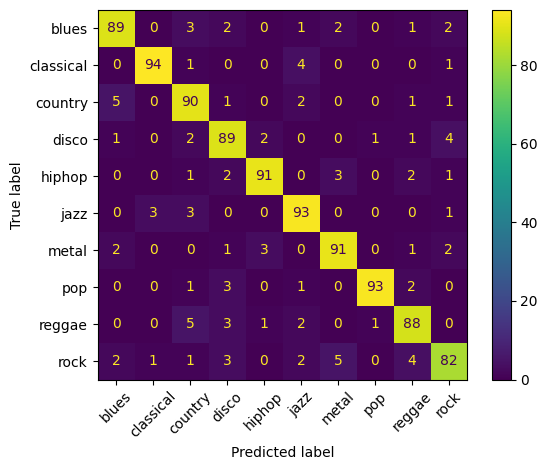

In [ ]:
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae',
                          'rock'])
disp.plot(xticks_rotation=45)
plt.show()

In [ ]:
df = d3sec
dtest = df.groupby('label').apply(lambda x: x.sample(100))
dtrain = df.drop([idx[1] for idx in dtest.index])

X_test, y_test = dtest.iloc[:, 2:-1], pd.Categorical(dtest['label']).codes
X_train, y_train = dtrain.iloc[:, 2:-1], pd.Categorical(dtrain['label']).codes

model = XGBClassifier()
model.fit(X_train, y_train)
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 90.40%


filename  length  chroma_stft_mean  chroma_stft_var  rms_mean  \
0     blues.00000.0.wav   66149          0.335406         0.091048  0.130405   
1     blues.00000.1.wav   66149          0.343065         0.086147  0.112699   
2     blues.00000.2.wav   66149          0.346815         0.092243  0.132003   
3     blues.00000.3.wav   66149          0.363639         0.086856  0.132565   
4     blues.00000.4.wav   66149          0.335579         0.088129  0.143289   
...                 ...     ...               ...              ...       ...   
9985   rock.00099.5.wav   66149          0.349126         0.080515  0.050019   
9986   rock.00099.6.wav   66149          0.372564         0.082626  0.057897   
9987   rock.00099.7.wav   66149          0.347481         0.089019  0.052403   
9988   rock.00099.8.wav   66149          0.387527         0.084815  0.066430   
9989   rock.00099.9.wav   66149          0.369293         0.086759  0.050524   

       rms_var  spectral_centroid_mean  spectral_centroid_var  \
0     0.003521             1773.065032          167541.630869   
1     0.001450             1816.693777           90525.690866   
2     0.004620             1788.539719          111407.437613   
3     0.002448             1655.289045          111952.284517   
4     0.001701             1630.656199           79667.267654   
...        ...                     ...                    ...   
9985  0.000097             1499.083005          164266.886443   
9986  0.000088             1847.965128          281054.935973   
9987  0.000701             1346.157659          662956.246325   
9988  0.000320             2084.515327          203891.039161   
9989  0.000067             1634.330126          411429.169769   

      spectral_bandwidth_mean  spectral_bandwidth_var  ...  mfcc16_var  \
0                 1972.744388           117335.771563  ...   39.687145   
1                 2010.051501            65671.875673  ...   64.748276   
2                 2084.565132            75124.921716  ...   67.336563   
3                 1960.039988            82913.639269  ...   47.739452   
4                 1948.503884            60204.020268  ...   30.336359   
...                       ...                     ...  ...         ...   
9985              1718.707215            85931.574523  ...   42.485981   
9986              1906.468492            99727.037054  ...   32.415203   
9987              1561.859087           138762.841945  ...   78.228149   
9988              2018.366254            22860.992562  ...   28.323744   
9989              1867.422378           119722.211518  ...   38.801735   

      mfcc17_mean  mfcc17_var  mfcc18_mean  mfcc18_var  mfcc19_mean  \
0       -3.241280   36.488243     0.722209   38.099152    -5.050335   
1       -6.055294   40.677654     0.159015   51.264091    -2.837699   
2       -1.768610   28.348579     2.378768   45.717648    -1.938424   
3       -3.841155   28.337118     1.218588   34.770935    -3.580352   
4        0.664582   45.880913     1.689446   51.363583    -3.392489   
...           ...         ...          ...         ...          ...   
9985    -9.094270   38.326839    -4.246976   31.049839    -5.625813   
9986   -12.375726   66.418587    -3.081278   54.414265   -11.960546   
9987    -2.524483   21.778994     4.809936   25.980829     1.775686   
9988    -5.363541   17.209942     6.462601   21.442928     2.354765   
9989   -11.598399   58.983097    -0.178517   55.761299    -6.903252   

      mfcc19_var  mfcc20_mean  mfcc20_var  label  
0      33.618073    -0.243027   43.771767  blues  
1      97.030830     5.784063   59.943081  blues  
2      53.050835     2.517375   33.105122  blues  
3      50.836224     3.630866   32.023678  blues  
4      26.738789     0.536961   29.146694  blues  
...          ...          ...         ...    ...  
9985   48.804092     1.818823   38.966969   rock  
9986   63.452255     0.428857   18.697033   rock  
9987   48.582378    -0.299545   41.586990   rock  
9988   24.843613     

In [ ]:
df = d3sec
dtest = df.groupby('label').apply(lambda x: x.sample(100))
dtrain = df.drop([idx[1] for idx in dtest.index])

X_test, y_test = dtest.iloc[:, 2:-1], pd.Categorical(dtest['label']).codes
X_train, y_train = dtrain.iloc[:, 2:-1], pd.Categorical(dtrain['label']).codes

model = XGBClassifier()
model.fit(X_train, y_train)
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 90.00%


In [ ]:
dtrain = xgb.DMatrix(data=X_train, label=y_train)

param = {'max_depth': 2, 'eta': 1, 'objective': 'multi:softmax'}
param['nthread'] = 4
param['eval_metric'] = 'auc'
param['num_class'] = 10

bst = xgb.train(param, dtrain)

# Vision Transformer


In [ ]:
vit = torchvision.models.vit_b_16(weights='ViT_B_16_Weights.DEFAULT')
num_ftrs = vit.fc.in_features
# Reset final fully connected layer
vit.fc = nn.Linear(num_ftrs, 10)

train_loss, train_acc, validation_loss, validation_acc = transfer_train(vit, vit.parameters(), device, train_loader, val_loader, epochs=15, lr=0.0001)

# Detach tensors from GPU
plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)

acc = plot_conf_mat(vit)

print('Test Accuracy:', acc)

AttributeError: ignored

# RAM FIX
run me we you run out of RAM in colab ;)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
import gc
# del variables
gc.collect()

56716

# AutoEncoder

In [ ]:
class AutoEncoder(nn.Module):
  def __init__(self):
    super(AutoEncoder, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=1, padding=0)
    self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=0)
    self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=0)
    self.conv4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=0)
    self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=0)
    self.fc1 = nn.Linear(in_features=9856, out_features=2)
    self.pool = nn.MaxPool2d(kernel_size=2)
    self.decoder = nn.Linear(in_features=2, out_features=10)
    self.norm1 = nn.BatchNorm2d(num_features=8)
    self.norm2 = nn.BatchNorm2d(num_features=16)
    self.norm3 = nn.BatchNorm2d(num_features=32)
    self.norm4 = nn.BatchNorm2d(num_features=64)
    self.norm5 = nn.BatchNorm2d(num_features=128)
    self.flatten = nn.Flatten()
    self.dropout = nn.Dropout(p=0.3, inplace=False)

  def encode(self, x):
    # Conv layer 1.
    x = self.pool(F.relu(self.norm1(self.conv1(x))))
    # Conv layer 2.
    x = self.pool(F.relu(self.norm2(self.conv2(x))))
    # Conv layer 3.
    x = self.pool(F.relu(self.norm3(self.conv3(x))))
    # Conv layer 4.
    x = self.pool(F.relu(self.norm4(self.conv4(x))))
    # Conv layer 5.
    x = self.pool(F.relu(self.norm5(self.conv5(x))))
    # Fully connected layer 1.
    x = self.fc1(self.dropout(self.flatten(x)))
    return x

  def decode(self, x):
    return self.decoder(x)

  def forward(self, x):
    x = self.encode(x)
    x = self.decode(x)
    return x


  0%|          | 0/30 [00:00<?, ?epoch/s]

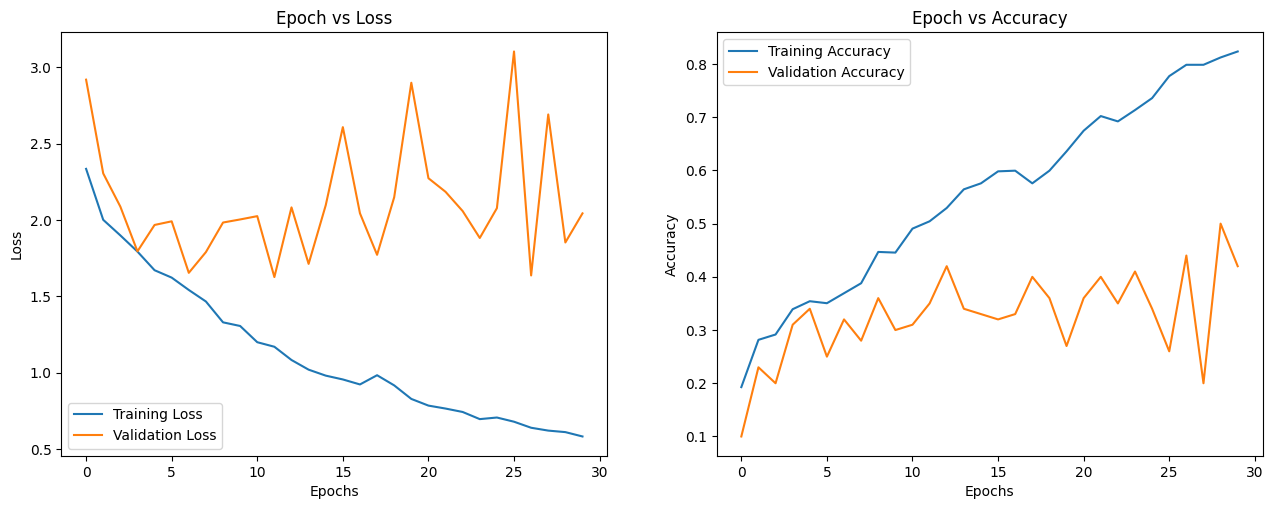

In [ ]:
# Run training.

ae = AutoEncoder().to(device)
train_loss, train_acc, validation_loss, validation_acc = train(ae, device, train_loader, val_loader, 30)

# Detach tensors from GPU
plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)

In [ ]:
latent, label = [], []
with torch.no_grad():
  for img, lbl in test_loader:
    latent.append(ae.encode(img.to(device)))
    label.append(lbl.to(device))

In [ ]:
label

[tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'),
 tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0'),
 tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3], device='cuda:0'),
 tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4], device='cuda:0'),
 tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5], device='cuda:0'),
 tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6], device='cuda:0'),
 tensor([7, 7, 7, 7, 7, 7, 7, 7, 7, 7], device='cuda:0'),
 tensor([8, 8, 8, 8, 8, 8, 8, 8, 8, 8], device='cuda:0'),
 tensor([9, 9, 9, 9, 9, 9, 9, 9, 9, 9], device='cuda:0')]

In [ ]:
x, y, z = np.zeros(100), np.zeros(100), np.zeros(100)
for i, ltt in enumerate(latent):
  for j in range(10):
    x[10*i + j] = ltt[j][0]
    y[10*i + j] = ltt[j][1]
    z[10*i + j] = i

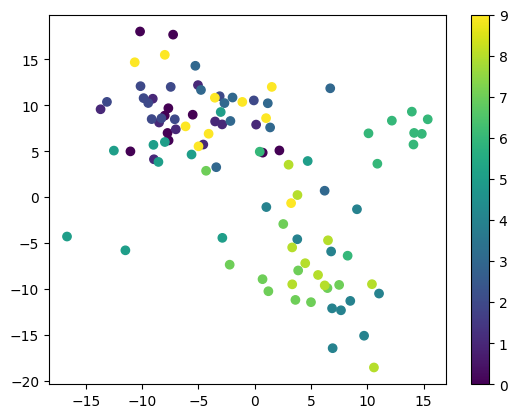

In [ ]:
plt.scatter(x, y, c=z)
plt.colorbar()

In [ ]:
test_dataset = datasets.ImageFolder(
    test_dir,
    transforms.Compose([
        transforms.ToTensor(),
    ]))

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=100, shuffle=False, num_workers=0)

pca = None
with torch.no_grad():
  for img, lbl in test_loader:
      pca = torch.pca_lowrank(net(img.to(device)), 2)

In [ ]:
xx = pca[0][:, 0].cpu().numpy()
yy = pca[0][:, 1].cpu().numpy()

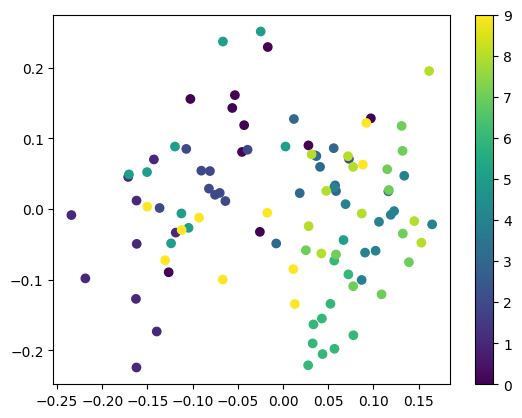

In [ ]:
plt.scatter(xx, yy, c=z)
plt.colorbar()

# resnet

In [ ]:
res_ae = torchvision.models.resnet18()
res_ae.fc = nn.Linear(res_ae.fc.in_features, 10)
res_ae.load_state_dict(torch.load('/content/gdrive/MyDrive/NMA/ResNet18_3sec_MV'))
# w = torch.load()

<All keys matched successfully>

In [ ]:
res_ae = torchvision.models.resnet18(weights=w)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
res_ae = res_ae.to(device)

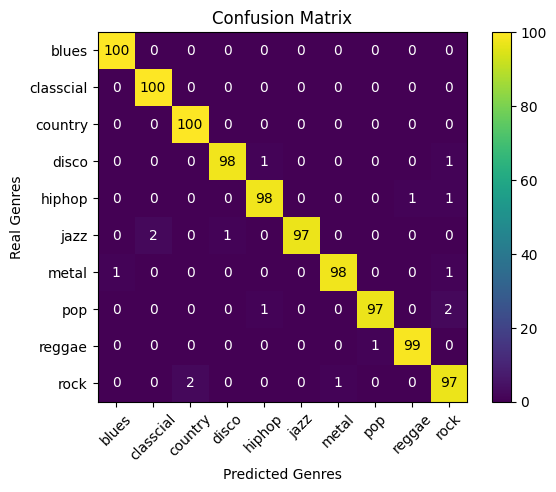

0.984

In [ ]:
plot_conf_mat(res_ae, three_sec=True)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


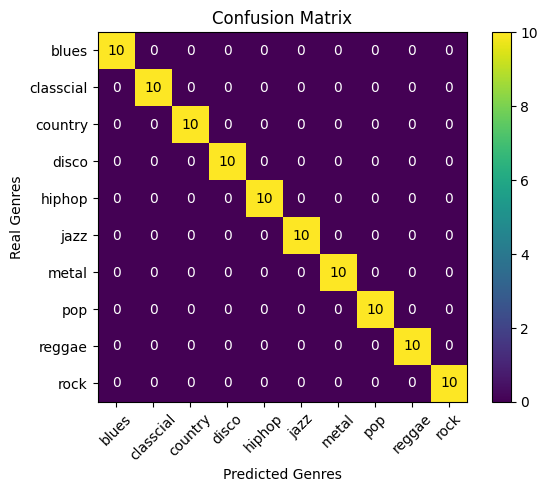

Majority Voting Accuracy= 1.0


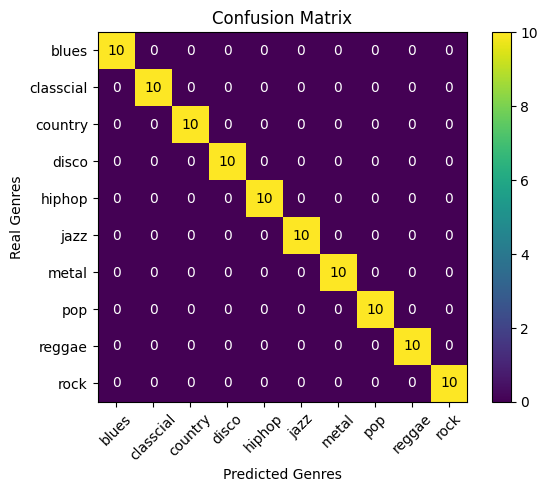

Probabilistic Accuracy= 1.0


In [ ]:
ensemble(res_ae, True)
ensemble(res_ae, False)

In [ ]:
print()

In [ ]:
! zip 3sec_dataset.zipfile gdrive/MyDrive/NMA/3sec

  adding: gdrive/MyDrive/NMA/3sec/ (stored 0%)
